<a href="https://colab.research.google.com/github/abdussahid26/LLM-Fine-tune-Projects/blob/main/Fine_tuning_spam_classification_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the dataset.

In [1]:
import urllib.request
import zipfile
import os
import ssl
from pathlib import Path


url="https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)


    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


Loading the dataset into a pandas DataFrame.

In [2]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Let's examine the class label distribution.

In [3]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


For simplicity, and because we prefer a small dataset (which will facilitate faster fine-tuning of the LLM), we choose to undersample the dataset to include 747 instances from each class.

In [4]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0] # Counts the instances of "spam"
    ham_subset = df[df["Label"] == "ham"].sample( # Randomly samples "ham" instance to match the number of "spam" instances
        num_spam, random_state=123
    )
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


Next, we convert the "string" class labels "ham" and "spam" into integer class labels 0 and 1, respectively.

In [5]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

This process is similar to converting text into token IDs. However, instead of using the GPT vocabular, which consists of 50,257 words, we are dealing with just two token IDs: 0 and 1.

Next, we create a random_split function to split the dataset into three parts: 70% for training, 10% for validation, and 20% for testing.

In [6]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(
            frac=1, random_state=123
        ).reset_index(drop=True) # Shuffle the entire DataFrame
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Splitting the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1) # Test size is simplified to be 0.2 as the remainder


Let's save the dataset as CSV files so we can reuse it later.

In [7]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

Now we will set up the PyTorch data loaders that will be used to train the model.

To batch these messages, we have two primary options:


1.   Truncate all messages to the length of the shortest message in the dataset or batch.
2.   Pad all messages to the length of the longest message in the dataset or batch.

The first option is computationally cheaper, but it may result in significant information loss if shorter messages are much smaller than the average or longest messages, potentially reducing model performance. So, we opt for the second option, which preserves the entire content of all messages.

To implement batching, where all messages are padded to the length of the longest message in the dataset, we add padding tokens to all shorter messages. For this purpose, we use **<|endoftext|>** as a padding token. However, instead of appending the string **<|endoftext|>** to each of the text messages directly, we can add the token ID corresponding to **<|endoftext|>** to the encoded text messages. 50256 is the token ID of the padding token **<|endoftext|>**.



In [8]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.0 MB/s eta 0:00:00


In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


We first need to implement a PyTorch Dataset, which specifies how the data is loaded and processed before we can instantiate the data loaders. It also identifies the longest sequence in the training dataset, encodes the text messages, and ensures that all other sequences are padded with a padding token to match the length of the longest sequence.

In [10]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncates sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        # Pads sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return(
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [11]:
train_dataset = SpamDataset(
    csv_file = "train.csv",
    max_length = None,
    tokenizer = tokenizer
)

val_dataset = SpamDataset(
    csv_file = "validation.csv",
    max_length = train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file = "test.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

In [12]:
print(train_dataset.max_length)
print(val_dataset.max_length)
print(test_dataset.max_length)

120
120
120


The code in the following listing creates the training, validation, and test set data loaders that load the text messages and labels in batch of size 8. For example, each batch will consist of eight training examples of length 120 and the corresponding class label of each example.

In [13]:
from torch.utils.data import DataLoader

num_workers = 0 # This setting ensures compatibility with most computers
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers,
    drop_last = True,
)

val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    drop_last = False,
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    num_workers = num_workers,
    drop_last = False,
)

To ensure that the data loaders are working and are, indeed, returning batches of the expected size, we iterate over the training loader and then print the tensor dimensions of the last batch.

In [14]:
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions: ", input_batch.shape)
print("Label batch dimensions: ", target_batch.shape)

Input batch dimensions:  torch.Size([8, 120])
Label batch dimensions:  torch.Size([8])


The input batches consist of eight training examples with 120 tokens each, as expected. The label tensor stores the class labels corresponding to the eight training examples.

In [15]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


Now that we've prepared the data, we need to prepare the model for fine-tuning.

**Initializing a model with pretrained weights**

In [16]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"],(
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize datasets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [17]:
import urllib.request

url = "https://raw.githubusercontent.com/abdussahid26/GPT-Model-from-Scratch-to-Generate-Text/main/gpt_download.py"
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7c071b3df790>)

In [18]:
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)

        return self.scale * norm_x + self.shift

In [19]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


In [20]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [21]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
    def forward(self, x):
        b, num_tokens, d_in = x.shape # Shape: (batch, num_tokens, d_in)
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a 'num_heads' dimension
        # Unroll last dim: (batch, num_tokens, d_out) -> (batch, num_tokens, num_tokens, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3) # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (batch, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [22]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x) # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        return x

In [23]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias = False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # The device setting will allow us to train the model on a CPU or GPU, depending on which device the input data sits on.
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits


In [24]:

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [25]:

import numpy as np

def load_weights_into_gpt(gpt, params): # Sets the model's positional and token embedding weights to those specified in params.
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"] ["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [26]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 54.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 5.63MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 125kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:07<00:00, 66.4MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.76MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 3.90MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 3.70MiB/s]


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [27]:
# idx is a (batch, n_tokens) array of indices in the current context
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g. if LLM supports only 5 tokens, and the context size is 10
        # then only last 5 tokens are used as context.
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) # dimension of logits tensor: [batch, num_tokens, vocabulary_size]

        # Focuses only on the last row, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]
        # Probs has shape (batch, vocab_size)
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)
        # idx_next has shape(batch, 1)
        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)
        # Append sample index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

After loading the model weights into the **GPTModel**, we reuse the text generation utility functions to ensure that the model generates coherent text.

In [28]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens = 15,
    context_size = BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


The model generated coherent text, which is indicates that the model weights have been loaded correctly.

Before we start fine-tuning the model as a spam classifier, let's see whether the model already classifies spam messages by prompting it with instructions.

In [29]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specifically selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(text_2, tokenizer),
    max_new_tokens = 23,
    context_size = BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specifically selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Based on the output, it's apparent that the model is **struggling** to follow instructions. This result is expected, as it has only undergone pretraining and lacks instruction fine-tuning. So let's prepare the model for classification fine-tuning.

**Adding a Classification Head**

In this section, we will modify the pretrained LLM to prepare it for classification fine-tuning. To do so, we replace the original output layer, which maps the hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to two classes: 0 ("not spam") and 1 ("spam"). We use the same model as before, except we replace the output layer.

To get the model ready for classification fine-tuning, we first **freeze** the model, meaning that we make all layers nontrainable.

In [30]:
for param in model.parameters():
    param.requires_grad = False

Let's replace the output layer (**model.out_head**), which originally maps the layer inputs to 50, 257 dimensions, the size of the vocabulary.

In [31]:
torch.manual_seed(123)
num_classes = 2 # Spam and ham
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)


This new **model.out_head** output layer has its **require_grad** attribute set to **True** by default, which means that it's the only layer in the model that will be updated during training. Additionally, we configure the **last transformer block** and **the final LayerNorm** module, which connects this block to the output layer, to be trainable. To make the **final LayerNorm** and **last transformer block** trainable, we set their respective **require_grad** to **True**.

In [32]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

Even though we added a new output layer and marked certain layers as trainable or nontrainable, we can stil use this model similarly to how we have previously. For instance, we can feed it an example text identical to our previously used example text.

In [33]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

print("Inputs: ", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs:  tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


Then, we can pass the encoded token IDs to the model as usual.

In [34]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs: \n", outputs)
print("Outputs dimensions: ", outputs.shape)

Outputs: 
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions:  torch.Size([1, 4, 2])


Remember that we are interested in fine-tuning this model to return a class label indicating whether a model input is "spam" or "not spam." We don't need to fine-tune all four output rows; instead, we can focus on a single output token. In particular, we will focus on the last row corresponding to the last output token. To extract the last output token from the output tensor, we use the following code.

In [35]:
print("Last output token:", outputs[:, -1, ])

Last output token: tensor([[-3.5983,  3.9902]])


The last token in a sequence of causal attention mask accumulates the most information since it is the only token with access to data from all the previous tokens. Therefore, in our spam classification task, we focus on this last token during the fine-tuning process.

We can obtain the class label.

In [36]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)

print(probas)
print("Class label: ", label.item())

tensor([[5.0598e-04, 9.9949e-01]])
Class label:  1


In this case, the code returns 1, meaning the model predicts that the input text is "spam." Using the softmax function here is optional because the largest outputs directly correspond to the highest probability scores. Hence, we can simplify the code without using softmax.

In [37]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)

print("Class label: ", label.item())

Class label:  1


This concept can be used to compute the classification accuracy, which measures the percentage of correct predictions across a dataset.

**Calculating the classification loss and accuracy**

To determine the classification accuracy, we apply the argmax-based prediction code to all examples in the dataset and calculate the proportion of correct predictions by defining a calc-accuracy_loader function.

In [38]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is not None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch) [:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    return correct_predictions / num_examples

Let's use the function to determine the classification accuracies across various datasets estimated from 10 batches for efficiency.

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches = 10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches = 10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}")

Training accuracy: 49.52%
Validation accuracy: 53.02%
Test accuracy: 50.33


As we can see, the prediction accuracies are near a random prediction, which would be 50% in this case. To improve the prediction accuracies, we need to fine-tune the model.

However, before we begin fine-tuning the model, we must define the loss function we will optimize during training. Our objective is to maximize the spam classification accuracy of the model, which means that the preceding code should output the correct class labels: 0 for non-spam and 1 for spam.

Accordingly, the **calc_loss_batch** function remains the same, with one adjustment: we focus on optimizing only the last token, model(input_batch)[:, -1, :], rather than all tokens, model(input_batch).

In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:, -1, :] # logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

We use the calc_loss_batch function to compute the loss for a single batch obtained from the previously defined data loaders. To calculate the loss for all batches in a dataloader, we define the calc_loss_loader function as before.

In [41]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

Let's compute the initial loss for each dataset.

In [42]:
with torch.no_grad(): # Disables gradient tracking for efficiency because we are not training yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches = 5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches = 5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches = 5)

print(f"Training loss: {train_loss:.4f}")
print(f"Validation loss: {val_loss:.4f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.4529
Validation loss: 2.5830
Test loss: 2.322


Next, we will implement a training function to fine-tune the model, which means adjusting the model to minimize the training set loss. Minimize the training set loss will help increase the classification accuracy, which is our overall goal.

**Fine-tuning the model on supervised data**

In this section, we define and use the training function to fine-tune the pretrained LLM and improve its spam classification accuracy. The training loop is the same overall training loop we used earlier, with the only difference being that we calculate the classification accuracy instead of generating a sample text to evaluate the model.

The training function also closely mirrors the train_model_simple function used for pretraining the model. The only two distinctions are that we now track the number of training examples seen (**examples_seen**) instead of the number of tokens, and we calculate the accuracy after each epoch instead of printing a sample text.

In [43]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs): # Main training loop
        model.train() # Sets model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Resets loss gradients from the previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculates loss gradients
            optimizer.step() # Updates model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: tracks examples instead of tokens [8, 120]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f"Training accuracy: {train_accuracy * 100: .2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy * 100: .2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [44]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

Next, we initialize the optimizer, set the number of training epochs, and initiate the training using the train_classifier_simple function.

In [45]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy:  72.12% | Validation accuracy:  73.15%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy:  84.62% | Validation accuracy:  85.23%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy:  87.21% | Validation accuracy:  91.28%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy:  94.90% | Validation accuracy:  95.30%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy:  97.21% | Validation accuracy:  97.32%
Training completed in

We then use Matplotlib to plot the loss function for the training and validation set.

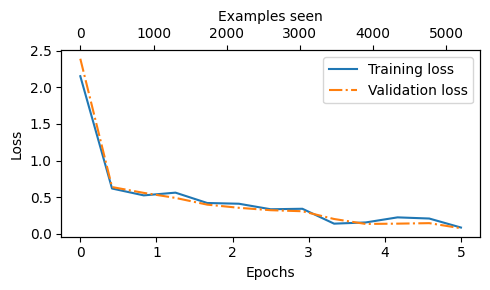

In [47]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()  # Creates a second x-axis for examples seen
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout() # Adults layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

As we can see based on the sharp downward slope, the model is learning well from the training data, and there is little to no indiction of overfitting; that is, there is no noticeable gap between the training and validation set losses.

Let's now plot the classification accuracies.

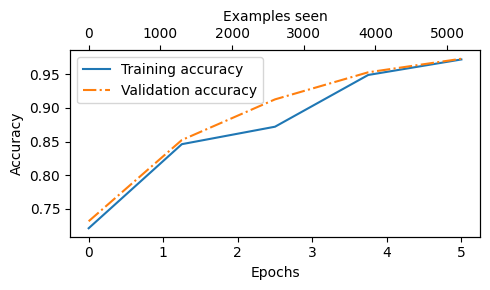

In [48]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

The model achieves a relatively high training and validation accuracy after epochs 4 and 5. Importantly, we previously set eval_iter=5 when using the train_classifier_simple function, which means our estimations of training and validation performance are based on only five batches for efficiency during training.

In [51]:
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=len(train_loader)) # Provide num_batches
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=len(val_loader)) # Provide num_batches
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=len(test_loader)) # Provide num_batches

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


The training and testset performance are almost identical. The slight discrepancy between the training and test set accuracies suggests minimal overfitting of the training data. Typically, the validation set accuracy is somewhat higher than the test set accuracy because the model development often involves tuning hyperparameters to perform well on the validation set, which might not generalize as effectively to the test set. This situation is common, but the gap could potentially be minimized by adjusting the model's settings, such as increasing the dropout rate (drop_rate) or the weight_decay parameter in the optimizer configuration.

Having fine-tuned and evaluated the model, we are now ready to classify spam messages.

**Using the LLM as a spam classifier**

Let's use our fine-tuned GPT-based spam classification model. The following following **classify_review** function follows data preprocessing steps similar to those we used in the **SpamDataset** implemented earlier. Then, after preprocessing, text into token IDs, the function uses the model to predict an integer class label.

In [52]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text) # Prepares inputs to the model
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)] # Truncates sequences if they are too long

    input_ids += [pad_token_id] * (max_length - len(input_ids)) # Pads sequences to the longest sequences

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # Adds batch dimension

    with torch.no_grad(): # Models inference without gradient tracking
        logits = model(input_tensor)[:, -1, :] # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam" # Returns the classified result

Let's try this classify_review function on an example text:

In [53]:
text_1 = (
    "You are a winner you have been specifically selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


The resulting model correctly predicts "spam".

In [54]:
text_2 = (
    "Hey, just wanted to check if we're still on for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


The model again makes a correct prediction and returns a "not spam" label.

Finally, let's save the model in case we want to reuse the model later without having to train it again. We can use the torch.save method.

In [59]:
torch.save(model.state_dict(), "review_classifier.pth")

Once saved, the model can be loaded by utilizing following code.

In [61]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<ipython-input-61-4d4235b68162>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load("review_classifier.pth", map_location=device)


<All keys matched successfully>